In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/roboflow'

/content/drive/My Drive/Colab Notebooks/roboflow


In [ ]:
!nvidia-smi

Tue Aug 13 20:24:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/My Drive/Colab Notebooks/roboflow


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.6/78.2 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0
from IPython import display

display.clear_output()

import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List
import numpy as np

def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))

def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
CLASS_NAMES_DICT = model.model.names
#class_ids person, car, motorcycle, bus and truck
CLASS_ID = [0, 2, 3, 5, 7]

for class_id, class_name in CLASS_NAMES_DICT.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Class ID: 0, Class Name: person
Class ID: 1, Class Name: bicycle
Class ID: 2, Class Name: car
Class ID: 3, Class Name: motorcycle
Class ID: 4, Class Name: airplane
Class ID: 5, Class Name: bus
Class ID: 6, Class Name: train
Class ID: 7, Class Name: truck
Class ID: 8, Class Name: boat
Class ID: 9, Class Name: traffic light
Class ID: 10, Class Name: fire hydrant
Class ID: 11, Class Name: stop sign
Class ID: 12, Class Name: parking meter
Class ID: 13, Class Name: bench
Class ID: 14, Class Name: bird
Class ID: 15, Class Name: cat
Class ID: 16, Class Name: dog
Class ID: 17, Class Name: horse
Class ID: 18, Class Name: sheep
Class ID: 19, Class Name: cow
Class ID: 20, Class Name: elephant
Class ID: 21, Class Name: bear
Class ID: 22, Class Name: zebra
Class ID: 23, Class Name: giraffe
Class ID: 24, Class Name: backpack
Class ID: 25, Class Name: umbrella
Class ID: 26, Class Name: handbag
Class ID: 27, Class Name: tie
Class ID: 28, Class Name: suitcase
Class ID: 29, Class Name: frisbee
Class ID:


0: 384x640 3 cars, 1 truck, 82.4ms
Speed: 4.1ms preprocess, 82.4ms inference, 720.0ms postprocess per image at shape (1, 3, 384, 640)


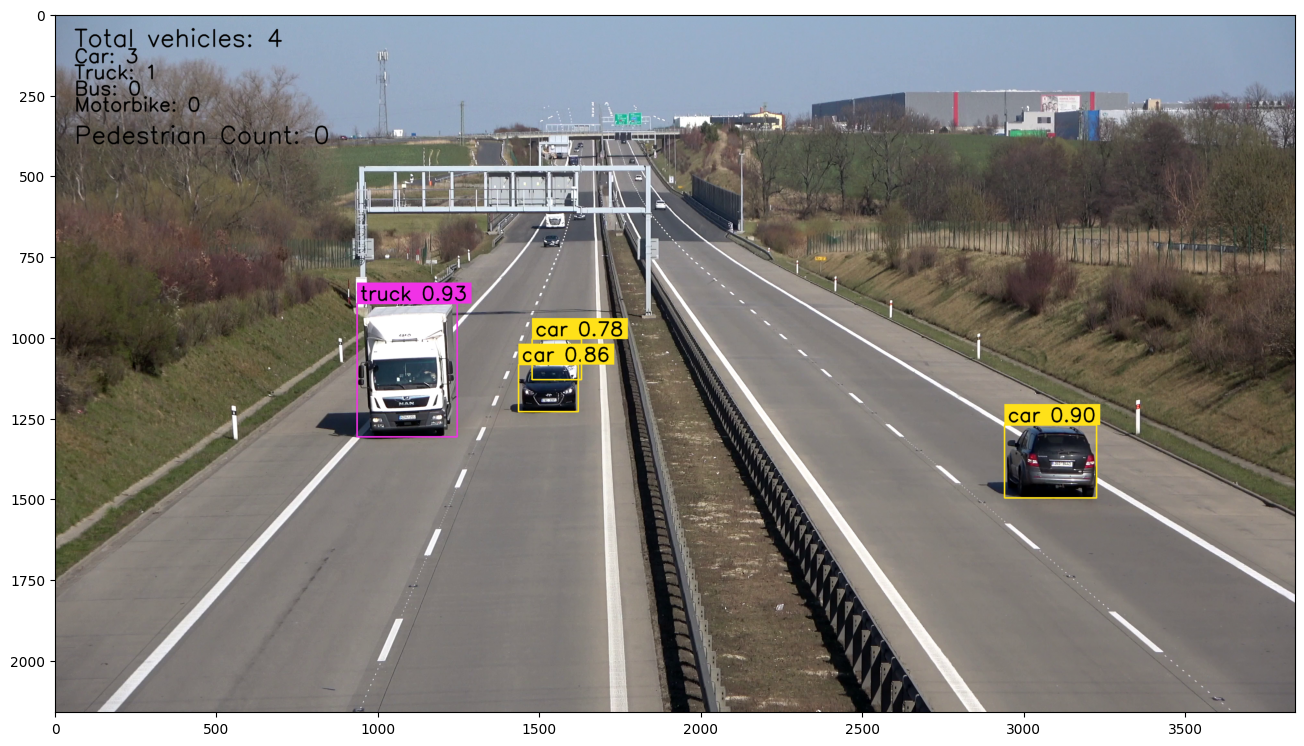

In [ ]:
import cv2

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
iterator = iter(generator)
frame = next(iterator)
results = model(frame)

detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for xyxy, confidence, class_id in zip(detections.xyxy, detections.confidence, detections.class_id)
]


frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

class_names = [CLASS_NAMES_DICT[class_id] for class_id in detections.class_id]
object_counts = {
    "person": class_names.count("person"),
    "car": class_names.count("car"),
    "truck": class_names.count("truck"),
    "bus": class_names.count("bus"),
    "motorbike": class_names.count("motorbike")
}

total_vehicles = sum(object_counts[vehicle] for vehicle in ["car", "truck", "bus", "motorbike"])
text = f"Total vehicles: {total_vehicles}"
cv2.putText(frame, text, (60, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 0), 3, cv2.LINE_AA)


total_persons = object_counts["person"]
text_total_persons = f"Pedestrian Count: {total_persons}"
cv2.putText(frame, text_total_persons, (60, 400), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 0), 3, cv2.LINE_AA)

text_car = f"Car: {object_counts['car']}"
text_truck = f"Truck: {object_counts['truck']}"
text_bus = f"Bus: {object_counts['bus']}"
text_motorbike = f"Motorbike: {object_counts['motorbike']}"

cv2.putText(frame, text_car, (60, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)
cv2.putText(frame, text_truck, (60, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)
cv2.putText(frame, text_bus, (60, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)
cv2.putText(frame, text_motorbike, (60, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/traffic1-counting-result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
!pip install numpy==1.23

In [ ]:
from tqdm.notebook import tqdm

byte_tracker = BYTETracker(BYTETrackerArgs())
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)



with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(generator, total=video_info.total_frames):
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)


        labels = [
            f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for xyxy, confidence, class_id in zip(detections.xyxy, detections.confidence, detections.class_id)
        ]


        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)



        class_names = [CLASS_NAMES_DICT[class_id] for class_id in detections.class_id]
        object_counts = {
            "person": class_names.count("person"),
            "car": class_names.count("car"),
            "truck": class_names.count("truck"),
            "bus": class_names.count("bus"),
            "motorbike": class_names.count("motorbike")
        }


        total_vehicles = sum(object_counts[vehicle] for vehicle in ["car", "truck", "bus", "motorbike"])
        text_total_vehicles = f"Total vehicles: {total_vehicles}"
        cv2.putText(frame, text_total_vehicles, (60, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 0), 3, cv2.LINE_AA)


        total_persons = object_counts["person"]
        text_total_persons = f"Pedestrian Count: {total_persons}"
        cv2.putText(frame, text_total_persons, (60, 400), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 0), 3, cv2.LINE_AA)


        text_car = f"Car: {object_counts['car']}"
        text_truck = f"Truck: {object_counts['truck']}"
        text_bus = f"Bus: {object_counts['bus']}"
        text_motorbike = f"Motorbike: {object_counts['motorbike']}"

        cv2.putText(frame, text_car, (60, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(frame, text_truck, (60, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(frame, text_bus, (60, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)
        cv2.putText(frame, text_motorbike, (60, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)

        sink.write_frame(frame)

  0%|          | 0/538 [00:00<?, ?it/s]


0: 384x640 3 cars, 1 truck, 62.3ms
Speed: 4.7ms preprocess, 62.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 62.0ms
Speed: 3.5ms preprocess, 62.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 2 trucks, 62.0ms
Speed: 3.3ms preprocess, 62.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 62.0ms
Speed: 3.4ms preprocess, 62.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 60.7ms
Speed: 3.3ms preprocess, 60.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 48.6ms
Speed: 3.5ms preprocess, 48.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 48.6ms
Speed: 3.6ms preprocess, 48.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 50.1ms
Speed: 3.4ms preprocess, 50.1ms 

YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


Processing Frames:   0%|          | 0/538 [00:00<?, ?it/s]


0: 384x640 3 cars, 1 truck, 48.4ms
Speed: 6.8ms preprocess, 48.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 47.0ms
Speed: 3.1ms preprocess, 47.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 2 trucks, 39.8ms
Speed: 3.9ms preprocess, 39.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 37.9ms
Speed: 5.7ms preprocess, 37.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 38.4ms
Speed: 3.2ms preprocess, 38.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 31.9ms
Speed: 3.3ms preprocess, 31.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 32.9ms
Speed: 3.2ms preprocess, 32.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 30.0ms
Speed: 3.7ms preprocess, 30.0ms 

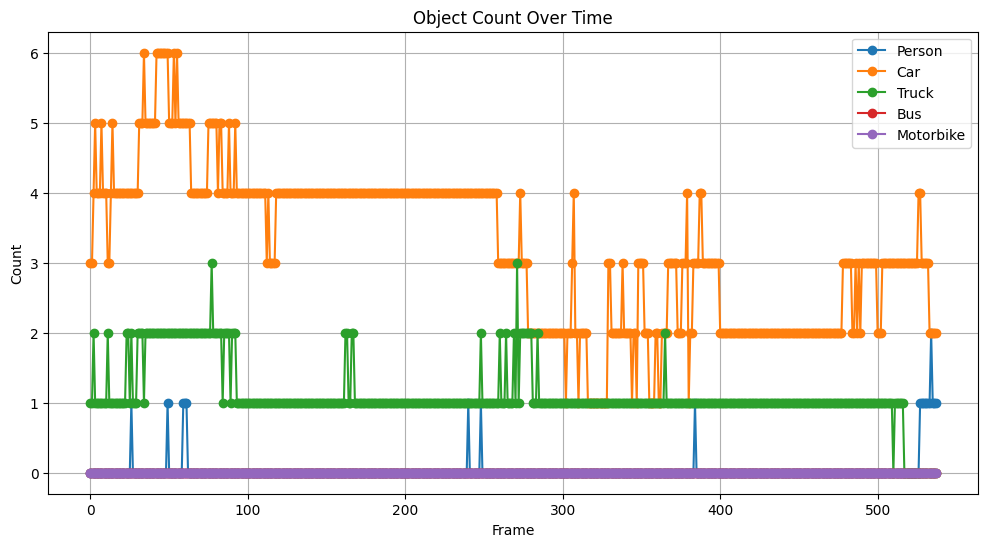

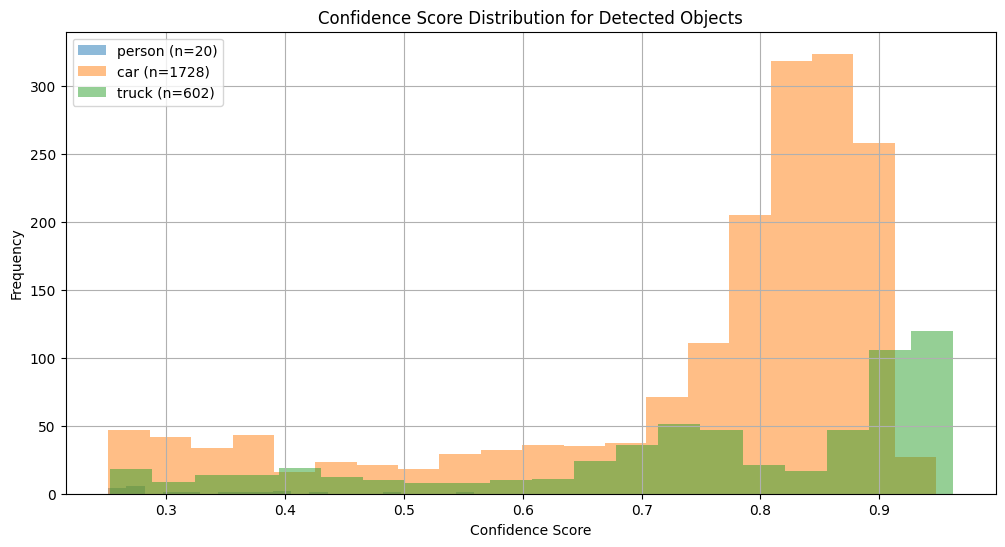

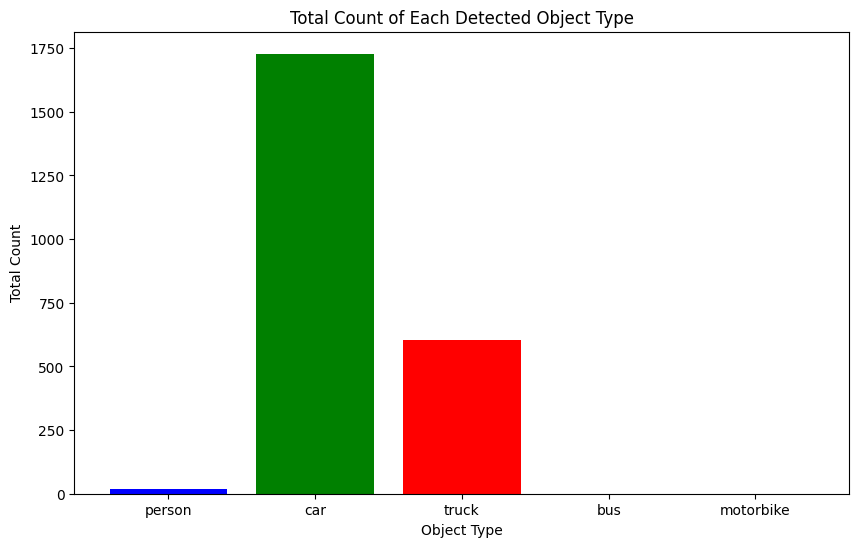

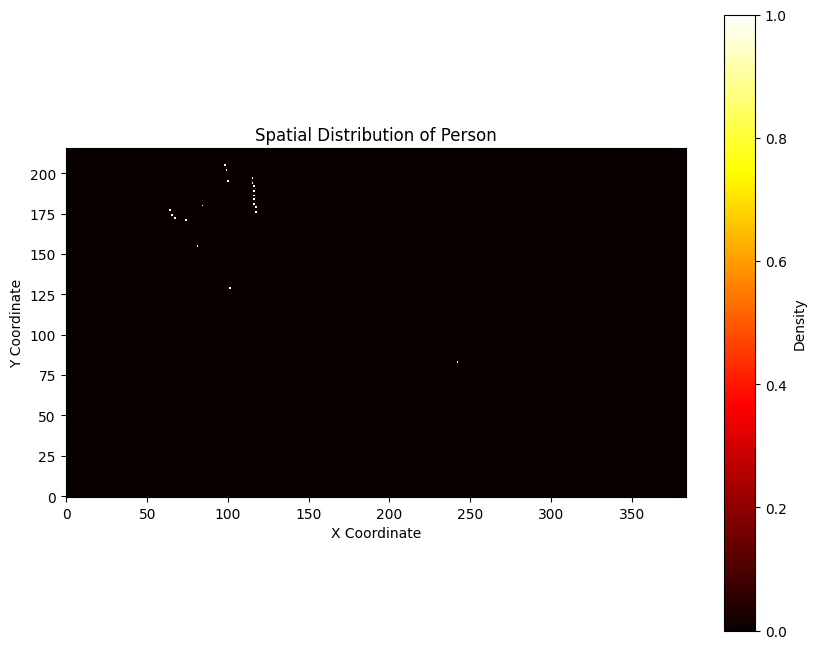

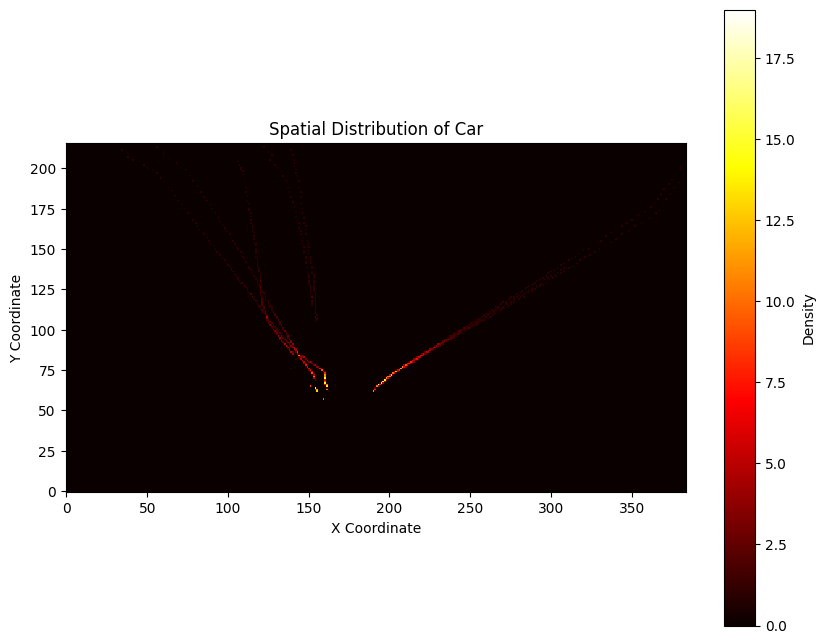

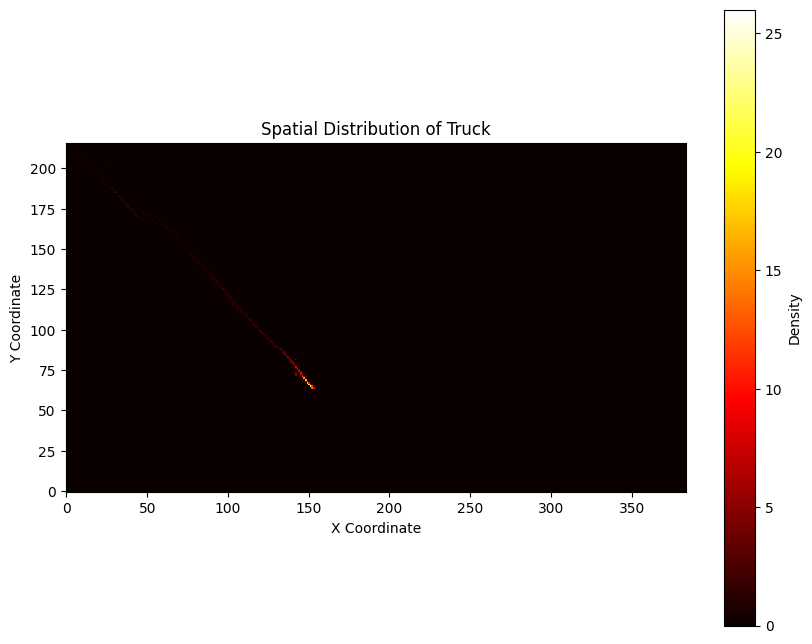

Class: person
  Average Confidence Score: 0.33
  Average Bounding Box Size: 8445.18

Class: car
  Average Confidence Score: 0.75
  Average Bounding Box Size: 21700.54

Class: truck
  Average Confidence Score: 0.75
  Average Bounding Box Size: 142926.80

Class: bus
  Average Confidence Score: 0.00
  Average Bounding Box Size: 0.00

Class: motorbike
  Average Confidence Score: 0.00
  Average Bounding Box Size: 0.00



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from tqdm.notebook import tqdm


def get_object_data_per_frame(video_path, model, class_names_dict, class_id_list):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    counts = {"frame": [], "person": [], "car": [], "truck": [], "bus": [], "motorbike": []}
    confidence_scores = { "person": [], "car": [], "truck": [], "bus": [], "motorbike": [] }
    positions = { "person": [], "car": [], "truck": [], "bus": [], "motorbike": [] }
    sizes = { "person": [], "car": [], "truck": [], "bus": [], "motorbike": [] }

    for frame_number in tqdm(range(frame_count), desc="Processing Frames"):
        ret, frame = video_capture.read()
        if not ret:
            break

        results = model(frame)
        detections = results[0].boxes

        class_ids = detections.cls.cpu().numpy().astype(int)
        confidences = detections.conf.cpu().numpy()
        bboxes = detections.xyxy.cpu().numpy()
        class_names = [class_names_dict[class_id] for class_id in class_ids if class_id in class_id_list]

        for class_id, confidence, bbox in zip(class_ids, confidences, bboxes):
            if class_id in class_id_list:
                class_name = class_names_dict[class_id]
                confidence_scores[class_name].append(confidence)
                positions[class_name].append(((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2))
                sizes[class_name].append((bbox[2] - bbox[0]) * (bbox[3] - bbox[1]))

        counts["frame"].append(frame_number)
        counts["person"].append(class_names.count("person"))
        counts["car"].append(class_names.count("car"))
        counts["truck"].append(class_names.count("truck"))
        counts["bus"].append(class_names.count("bus"))
        counts["motorbike"].append(class_names.count("motorbike"))

    video_capture.release()
    return counts, confidence_scores, positions, sizes


def plot_time_series(counts):
    plt.figure(figsize=(12, 6))
    plt.plot(counts["frame"], counts["person"], label="Person", marker='o')
    plt.plot(counts["frame"], counts["car"], label="Car", marker='o')
    plt.plot(counts["frame"], counts["truck"], label="Truck", marker='o')
    plt.plot(counts["frame"], counts["bus"], label="Bus", marker='o')
    plt.plot(counts["frame"], counts["motorbike"], label="Motorbike", marker='o')

    plt.xlabel("Frame")
    plt.ylabel("Count")
    plt.title("Object Count Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_confidence_score_distribution(confidence_scores):
    plt.figure(figsize=(12, 6))
    for class_name, scores in confidence_scores.items():
        if scores:
            plt.hist(scores, bins=20, alpha=0.5, label=f"{class_name} (n={len(scores)})")

    plt.xlabel("Confidence Score")
    plt.ylabel("Frequency")
    plt.title("Confidence Score Distribution for Detected Objects")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_object_count_summary(counts):
    total_counts = {
        "person": sum(counts["person"]),
        "car": sum(counts["car"]),
        "truck": sum(counts["truck"]),
        "bus": sum(counts["bus"]),
        "motorbike": sum(counts["motorbike"])
    }

    object_types = list(total_counts.keys())
    object_counts = list(total_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(object_types, object_counts, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.xlabel("Object Type")
    plt.ylabel("Total Count")
    plt.title("Total Count of Each Detected Object Type")
    plt.show()


def plot_spatial_distribution_heatmaps(positions, frame_shape):
    heatmap_size = (frame_shape[1], frame_shape[0])
    for class_name, pos_list in positions.items():
        if pos_list:
            heatmap, xedges, yedges = np.histogram2d(
                [pos[0] for pos in pos_list], [pos[1] for pos in pos_list],
                bins=[heatmap_size[0] // 10, heatmap_size[1] // 10],
                range=[[0, heatmap_size[0]], [0, heatmap_size[1]]]
            )
            heatmap = heatmap.T

            plt.figure(figsize=(10, 8))
            plt.imshow(heatmap, cmap='hot', interpolation='nearest')
            plt.title(f"Spatial Distribution of {class_name.capitalize()}")
            plt.colorbar(label='Density')
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            plt.gca().invert_yaxis()
            plt.show()


def class_specific_analysis(confidence_scores, sizes):
    for class_name in confidence_scores.keys():
        avg_confidence = np.mean(confidence_scores[class_name]) if confidence_scores[class_name] else 0
        avg_size = np.mean(sizes[class_name]) if sizes[class_name] else 0
        print(f"Class: {class_name}")
        print(f"  Average Confidence Score: {avg_confidence:.2f}")
        print(f"  Average Bounding Box Size: {avg_size:.2f}")
        print()


MODEL = "yolov8x.pt"
CLASS_NAMES_DICT = {
    0: "person",
    2: "car",
    3: "motorbike",
    5: "bus",
    7: "truck"
}
CLASS_ID = [0, 2, 3, 5, 7]


model = YOLO(MODEL)
model.fuse()


SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

counts, confidence_scores, positions, sizes = get_object_data_per_frame(SOURCE_VIDEO_PATH, model, CLASS_NAMES_DICT, CLASS_ID)

plot_time_series(counts)

plot_confidence_score_distribution(confidence_scores)

plot_object_count_summary(counts)

cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
ret, frame = cap.read()
if ret:
    frame_shape = frame.shape
    plot_spatial_distribution_heatmaps(positions, frame_shape)
cap.release()

class_specific_analysis(confidence_scores, sizes)
